In [3]:
import requests
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timezone, timedelta

# ── Electricity Maps API ──────────────────────────────────────────────
ZONE = "US-TEX-ERCO"
TOKEN = "4N4rpoLvWqfvQ0yJdHN0"
BASE = "https://api.electricitymaps.com/v3/carbon-intensity"
HEADERS = {"auth-token": TOKEN}

def fetch_carbon_intensity_history() -> list[dict]:
    """Fetch recent hourly carbon intensity history for the zone."""
    
    r = requests.get(f"{BASE}/history", params={"zone": ZONE,  "temporalGranularity": "5_minutes"}, headers=HEADERS)
    r.raise_for_status()
    return r.json()["history"]

def fetch_carbon_intensity_forecast() -> list[dict]:
    """Fetch hourly carbon intensity forecast for the zone."""
    r = requests.get(f"{BASE}/forecast", params={"zone": ZONE,  "temporalGranularity": "5_minutes"}, headers=HEADERS)
    r.raise_for_status()
    return r.json()["forecast"]

# Fetch both history and forecast
history = fetch_carbon_intensity_history()
forecast = fetch_carbon_intensity_forecast()

# Build a unified timeline (datetime → gCO₂eq/kWh)
def parse_dt(s: str) -> datetime:
    return datetime.fromisoformat(s.replace("Z", "+00:00"))

ci_timeline: dict[datetime, float] = {}
for entry in history:
    ci_timeline[parse_dt(entry["datetime"])] = entry["carbonIntensity"]
for entry in forecast:
    dt = parse_dt(entry["datetime"])
    if dt not in ci_timeline:          # forecast fills in future hours
        ci_timeline[dt] = entry["carbonIntensity"]

# Sort by time
ci_times = np.array(sorted(ci_timeline.keys()))
ci_values = np.array([ci_timeline[t] for t in ci_times])    # gCO₂eq/kWh

print(f"Carbon-intensity timeline: {ci_times[0]} → {ci_times[-1]}  ({len(ci_times)} points)")
print(f"  min = {ci_values.min():.0f},  max = {ci_values.max():.0f},  mean = {ci_values.mean():.0f} gCO₂eq/kWh")

Carbon-intensity timeline: 2026-02-21 02:40:00+00:00 → 2026-02-23 02:55:00+00:00  (580 points)
  min = 126,  max = 588,  mean = 346 gCO₂eq/kWh


In [ ]:
def create_co2_interpolator(ci_times, ci_values):
    """
    Creates a function f(t) that returns the carbon intensity at time t (in seconds)
    after the first data point in ci_times.
    """
    # Convert datetime objects to seconds relative to the first timestamp
    t0 = ci_times[0]
    times_seconds = np.array([(t - t0).total_seconds() for t in ci_times])
    
    def f(t: float | np.ndarray) -> float | np.ndarray:
        """
        Returns the interpolated carbon intensity (gCO₂eq/kWh) at time t (seconds)
        after the start of the timeline.
        """
        return np.interp(t, times_seconds, ci_values)
    
    return f

# Create the interpolator function
co2_per_kwh_t = create_co2_interpolator(ci_times, ci_values)

import json

def create_power_function(json_path: str):
    """
    Reads message.json and creates a stepwise function g(t) that returns 
    the power in kW at time t (seconds).
    
    The JSON contains:
      - profiled_step_energy_J : energy per step for the profiled epochs only
      - step_time_s            : time per step for ALL steps (full run)
    
    We tile the profiled energy pattern to cover all steps, then pair each
    step with its actual timing from step_time_s.
    """
    with open(json_path, 'r') as f:
        data = json.load(f)
    
    profiled_energy_j = np.array(data["profiled_step_energy_J"])  # shape: (n_profiled,)
    time_s = np.array(data["step_time_s"])                        # shape: (total_steps,)
    
    total_steps = len(time_s)
    n_profiled = len(profiled_energy_j)
    
    # Tile the profiled energy pattern to cover all steps
    repeats = int(np.ceil(total_steps / n_profiled))
    energy_j = np.tile(profiled_energy_j, repeats)[:total_steps]  # shape: (total_steps,)
    
    # Power (kW) = Energy (J) / Time (s) / 1000
    power_kw = (energy_j / time_s) / 1000.0
    
    # Cumulative time boundaries: t=0 is the start of the first step
    cumulative_time = np.concatenate(([0.0], np.cumsum(time_s)))
    
    print(f"  profiled steps: {n_profiled},  total steps: {total_steps}")
    print(f"  total run time: {cumulative_time[-1]:.1f} s ({cumulative_time[-1]/3600:.2f} h)")
    
    def g(t: float | np.ndarray) -> float | np.ndarray:
        """
        Returns the power in kW at time t (seconds).
        Uses a stepwise function (constant power during each step).
        """
        idx = np.searchsorted(cumulative_time, t, side='right') - 1
        
        if isinstance(t, np.ndarray):
            result = np.zeros_like(t, dtype=float)
            valid_mask = (t >= 0) & (t < cumulative_time[-1])
            result[valid_mask] = power_kw[idx[valid_mask]]
            return result
        else:
            if t < 0 or t >= cumulative_time[-1]:
                return 0.0
            return power_kw[idx]
            
    return g, cumulative_time, power_kw

# Create the power function
json_file_path = "/Users/hristostefanov/Python/CaSch/casch/data/real_data.json"
kw_t, step_times, step_powers = create_power_function(json_file_path)

FileNotFoundError: [Errno 2] No such file or directory: 'data/real_data.json'

In [ ]:
with open("/Users/hristostefanov/Python/CaSch/casch/data/real_data.json", 'r') as f:
    data = json.load(f)
    
profiled_energy_j = np.array(data["profiled_step_energy_J"])  # shape: (n_profiled,)
time_s = np.array(data["step_time_s"])                        # shape: (total_steps,)
    

In [ ]:
profiled_energy_j[-10:]

array([7.9398, 7.9949, 8.0001, 7.9483, 7.9762, 7.9845, 7.9139, 8.0146,
       7.9498, 5.8863])

In [ ]:
kw_t(0), kw_t(10), kw_t(100), kw_t(1000), kw_t(6055)

(0.249979638505153,
 0.24998433583959903,
 0.24998920252969306,
 0.24998303987171977,
 0.24998123827392119)

In [ ]:
with open("/Users/hristostefanov/Python/CaSch/casch/data/message.json", 'r') as f:
    data = json.load(f)

In [ ]:
sum(data["step_time_s"])

6055.672975

In [ ]:
len(ci_times)

585

In [ ]:
ci_values[-100:], ci_times

(array([320, 279, 294, 214, 252, 244, 243, 315, 295, 265, 323, 208, 216,
        257, 263, 233, 262, 235, 309, 270, 195, 291, 317, 251, 207, 321,
        300, 221, 290, 205, 303, 225, 302, 206, 287, 283, 303, 221, 256,
        272, 228, 231, 240, 186, 249, 281, 263, 209, 254, 241, 274, 259,
        268, 200, 267, 255, 231, 179, 219, 277, 240, 269, 198, 246, 266,
        220, 258, 185, 265, 270, 206, 224, 234, 281, 270, 231, 278, 216,
        334, 277, 206, 242, 298, 321, 305, 265, 323, 264, 366, 434, 345,
        488, 379, 378, 503, 457, 481, 460, 398, 460]),
 array([datetime.datetime(2026, 2, 20, 23, 15, tzinfo=datetime.timezone.utc),
        datetime.datetime(2026, 2, 20, 23, 20, tzinfo=datetime.timezone.utc),
        datetime.datetime(2026, 2, 20, 23, 25, tzinfo=datetime.timezone.utc),
        datetime.datetime(2026, 2, 20, 23, 30, tzinfo=datetime.timezone.utc),
        datetime.datetime(2026, 2, 20, 23, 35, tzinfo=datetime.timezone.utc),
        datetime.datetime(2026, 2, 20, 23, 4

In [ ]:
# Test the interpolator
t_test = np.array([0, 150, 300, 450]) # 0, 2.5, 5, 7.5 minutes in seconds
print(f"Interpolated values at t={t_test} seconds:")
print(co2_per_kwh_t(t_test))

Interpolated values at t=[  0 150 300 450] seconds:
[294.  341.5 389.  386.5]


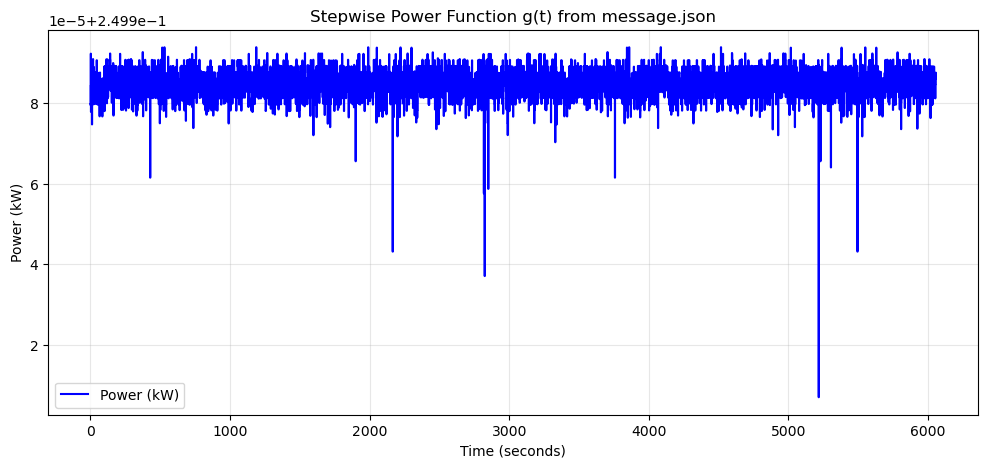

Total duration: 6055.64 seconds
Average power: 0.2500 kW
Max power: 0.2500 kW


In [ ]:
# Plot the stepwise power function g(t)
import matplotlib.pyplot as plt

# Create a dense time array to show the stepwise nature
t_max = step_times[-2]
t_plot = np.linspace(0, t_max, 5000)
power_plot = kw_t(t_plot)

plt.figure(figsize=(12, 5))
plt.plot(t_plot, power_plot, label='Power (kW)', color='blue', drawstyle='steps-post')
plt.xlabel('Time (seconds)')
plt.ylabel('Power (kW)')
plt.title('Stepwise Power Function g(t) from message.json')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

# Print some stats
print(f"Total duration: {t_max:.2f} seconds")
print(f"Average power: {np.mean(step_powers):.4f} kW")
print(f"Max power: {np.max(step_powers):.4f} kW")